### 本篇代码用于处理文本数据，得到合适的格式方便建模

In [1]:
import pandas as pd
import numpy as np
import tensorflow
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle("Pickles/text_and_finance.pkl")
df.head()

,GICS Sector,GICS Sub Industry,cik,doc_name,items,release_date,text,ticker,txt_link,rm_week,rm_month,rm_qtr,rm_year,vix,price_change,signal
0,Information Technology,Information Technology,789019.0,0001193125-19-022553.txt,"[Item 2.02, Item 9.01]",2019-01-30 16:03:36,0001193125-19-022553.txt : 20190130 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,-3.80,0.61,2.12,20.47,17.66,-1.82,down
1,Information Technology,Information Technology,789019.0,0001193125-18-337951.txt,[Item 5.07],2018-11-29 15:29:57,0001193125-18-337951.txt : 20181129 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,6.77,0.11,-0.01,23.76,18.65,-0.95,stay
2,Information Technology,Information Technology,789019.0,0001193125-18-306365.txt,"[Item 2.02, Item 9.01]",2018-10-24 16:03:06,0001193125-18-306365.txt : 20181024 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,-0.91,-1.60,1.60,37.85,25.23,4.71,up
3,Information Technology,Information Technology,789019.0,0001193125-18-277602.txt,"[Item 5.02, Item 9.01]",2018-09-19 16:15:58,0001193125-18-277602.txt : 20180919 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,1.02,2.87,9.60,42.83,11.75,1.35,up
4,Information Technology,Information Technology,789019.0,0001193125-18-221458.txt,"[Item 2.02, Item 9.01]",2018-07-19 16:02:35,0001193125-18-221458.txt : 20180719 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,0.66,5.09,8.96,38.96,12.87,5.21,up


## 主要步骤
1. Remove extra whitespace
2. Tokenize
3. Remove punctuation, stopwords, convert to lower case
4. Lemmatize
5. Load pre-trained word embeddings

In [3]:

from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
wordnet_lemmatizer = WordNetLemmatizer()
import string
punctuations = string.punctuation
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar

In [4]:
pd.options.mode.chained_assignment = None

定义函数一次性处理文本数据，利用多线程加速

In [9]:

def nltk_tokenizer(text):
    try:
        tokens = [word for word in word_tokenize(text) if word.isalpha()] #tokenize并只保留字母单词
        tokens = list(filter(lambda t: t not in punctuations, tokens)) #去掉标点
        tokens = list(filter(lambda t: t.lower() not in stop_words, tokens)) #去掉停用词，变成小写
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)
        filtered_tokens = list(
            map(lambda token: wordnet_lemmatizer.lemmatize(token.lower()), filtered_tokens)) #lemmatize
        filtered_tokens = list(filter(lambda t: t not in punctuations, filtered_tokens))
        return filtered_tokens
    except Exception as e:
        raise e

def dask_tokenizer(df):
    df['processed_text'] = df['text'].map(nltk_tokenizer)
    df['text_len'] = df['processed_text'].map(lambda x: len(x))
    return df

In [10]:
pbar = ProgressBar()
pbar.register()
ddata = dd.from_pandas(df, npartitions=20)
df = ddata.map_partitions(dask_tokenizer).compute()

[########################################] | 100% Completed | 37min 42.8s


In [11]:
df.head()

,GICS Sector,GICS Sub Industry,cik,doc_name,items,release_date,text,ticker,txt_link,rm_week,rm_month,rm_qtr,rm_year,vix,price_change,signal,processed_text,text_len
0,Information Technology,Information Technology,789019.0,0001193125-19-022553.txt,"[Item 2.02, Item 9.01]",2019-01-30 16:03:36,0001193125-19-022553.txt : 20190130 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,-3.80,0.61,2.12,20.47,17.66,-1.82,down,"[accession, number, conformed, submission, typ...",980
1,Information Technology,Information Technology,789019.0,0001193125-18-337951.txt,[Item 5.07],2018-11-29 15:29:57,0001193125-18-337951.txt : 20181129 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,6.77,0.11,-0.01,23.76,18.65,-0.95,stay,"[accession, number, conformed, submission, typ...",279
2,Information Technology,Information Technology,789019.0,0001193125-18-306365.txt,"[Item 2.02, Item 9.01]",2018-10-24 16:03:06,0001193125-18-306365.txt : 20181024 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,-0.91,-1.60,1.60,37.85,25.23,4.71,up,"[accession, number, conformed, submission, typ...",838
3,Information Technology,Information Technology,789019.0,0001193125-18-277602.txt,"[Item 5.02, Item 9.01]",2018-09-19 16:15:58,0001193125-18-277602.txt : 20180919 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,1.02,2.87,9.60,42.83,11.75,1.35,up,"[accession, number, conformed, submission, typ...",474
4,Information Technology,Information Technology,789019.0,0001193125-18-221458.txt,"[Item 2.02, Item 9.01]",2018-07-19 16:02:35,0001193125-18-221458.txt : 20180719 0001193125...,MSFT,https://www.sec.gov/Archives/edgar/data/789019...,0.66,5.09,8.96,38.96,12.87,5.21,up,"[accession, number, conformed, submission, typ...",1332


In [12]:
df.to_csv("Data/lemmatized_text.csv",chunksize=1000)

In [14]:

df['items'] = df['items'].map(lambda items: [' '.join(x.split()) for x in items])

In [13]:
df.to_pickle("Pickles\\lemmatized_text.pkl")

查看文本长度分布，发现几万以上的多是乱码，0.9分位可取

In [5]:
df = pd.read_pickle("Pickles\\lemmatized.pkl")

In [10]:
df['text_len'].describe()

count    3.845000e+03
mean     1.308959e+04
std      4.885380e+04
min      1.260000e+02
25%      6.960000e+02
50%      1.855000e+03
75%      7.332000e+03
max      1.366310e+06
Name: text_len, dtype: float64

In [20]:
int(df['text_len'].quantile(.9))

23089

In [7]:
len(df)

3845

取文本长度为0.9分位，剩余样本3460个

In [26]:
df = df.loc[df['text_len']<23089]
len(df)

3460

In [32]:
from datetime import datetime

In [46]:
a = datetime(2015,1,1)#取2015年1月1日到2019年4月1日

In [47]:
df = df.loc[df['release_date']>=a]

最终样本数量3426个

In [48]:
len(df)

3426

In [52]:
df.to_pickle("Pickles\\processed_data.pkl")

#### 得到数据的基本特征描述

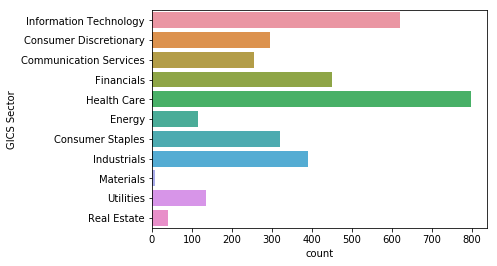

In [51]:
sns.countplot(y=df['GICS Sector'])
plt.savefig("Graphs/sectors.png",format="png")
plt.show()

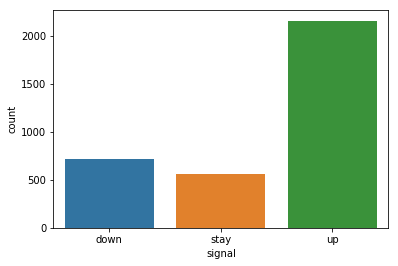

In [50]:
#Count plot of signals
sns.countplot(df['signal'])
plt.savefig("Graphs/signal.png",format="png")
plt.show()

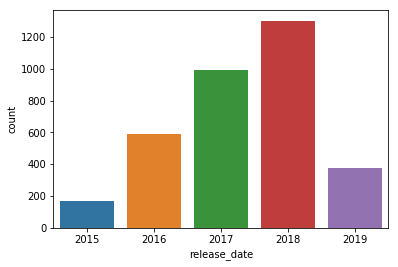

In [49]:
#df['release_date'] = df['release_date'].map(lambda x: pd.to_datetime(x))
sns.countplot(pd.DatetimeIndex(df['release_date']).year)
plt.savefig("Graphs/year.png",format="png")
plt.show()

In [2]:
df = pd.read_pickle("Pickles\\processed_data.pkl")

In [3]:
df.describe()

,cik,rm_week,rm_month,rm_qtr,rm_year,vix,price_change,text_len,sentiment
count,3.426000e+03,3241.000000,3242.000000,3236.000000,3181.000000,3426.000000,3244.000000,3426.000000,3426.000000
mean,6.381226e+05,0.142299,0.925469,2.490637,11.589249,14.667697,4.492127,3644.012259,-0.259193
std,5.144178e+05,2.658491,5.370084,9.500858,25.874663,4.220049,20.308287,4923.191543,0.484291
min,1.800000e+03,-16.280000,-31.020000,-37.230000,-62.970000,9.010000,-53.480000,126.000000,-1.000000
25%,8.042400e+04,-1.090000,-2.117500,-3.415000,-3.780000,11.492500,0.190000,598.250000,-0.596703
50%,7.327170e+05,0.200000,0.960000,2.540000,9.420000,13.485000,2.610000,1607.000000,-0.285714
75%,1.065280e+06,1.440000,3.910000,8.020000,22.810000,16.622500,5.562500,3889.000000,0.000000
max,1.730168e+06,36.460000,37.390000,62.610000,290.940000,37.320000,233.260000,23070.000000,1.000000


处理缺失值

In [5]:
df = df.fillna(0)

In [6]:
df.describe()

,cik,rm_week,rm_month,rm_qtr,rm_year,vix,price_change,text_len,sentiment
count,3.426000e+03,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000,3426.000000
mean,6.381226e+05,0.134615,0.875765,2.352510,10.760479,14.667697,4.253491,3644.012259,-0.259193
std,5.144178e+05,2.585896,5.228011,9.251155,25.110309,4.220049,19.787017,4923.191543,0.484291
min,1.800000e+03,-16.280000,-31.020000,-37.230000,-62.970000,9.010000,-53.480000,126.000000,-1.000000
25%,8.042400e+04,-0.987500,-1.895000,-2.990000,-2.737500,11.492500,0.000000,598.250000,-0.596703
50%,7.327170e+05,0.070000,0.610000,2.015000,7.540000,13.485000,2.345000,1607.000000,-0.285714
75%,1.065280e+06,1.357500,3.740000,7.550000,21.667500,16.622500,5.290000,3889.000000,0.000000
max,1.730168e+06,36.460000,37.390000,62.610000,290.940000,37.320000,233.260000,23070.000000,1.000000


In [7]:
df.to_pickle("Pickles\\processed_data.pkl")